In [20]:
import pandas as pd
from collections import Counter
import nltk
import os
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import numpy as np
import json
import shutil
import pickle


import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [6]:
file_data = json.load(open(os.path.expanduser("~/ServiceAccountsKey.json")))
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(
    ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

noscemus_gs = gc.open_by_url(
    "https://docs.google.com/spreadsheets/d/1ekf9RBfd4yqy0p0IWJ4SDk1kUT70hnoIVX1H6KPdIts/edit?usp=sharing")


In [7]:
metadata_table_long = pd.read_csv("../data/metadata_table_long.csv")


In [8]:
len(metadata_table_long)

975

In [9]:
metadata_table_long.head(5)

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,...,Of interest to,Transkribus text available,Written by,Library and Signature,ids,id,date_min,date_max,filename,file_year
0,"Achrelius, Daniel",Scientiarum magnes recitatus publice anno 1690...,NaN,1690,[Turku],Wall,17th century,Oration,"Mathematics, Astronomy/Astrology/Cosmography, ...",Scientiarum magnes(Google Books),...,"MK, JL",Yes,IT,NaN,[705665],705665,1690.0,1690.0,"Achrelius,_Daniel_-_Scientiarum_magnes__Turku_...",1690.0
1,"Acidalius, Valens","Ad Iordanum Brunum Nolanum, Italum","Poematum Iani Lernutii, Iani Gulielmi, Valenti...",1603,"Liegnitz, Wrocław","Albert, David",17th century,Panegyric poem,Astronomy/Astrology/Cosmography,Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...,...,"MK, IT",Yes,MK,NaN,[801745],801745,1603.0,1603.0,Janus_Lernutius_et_al__-_Poemata__Liegnitz_160...,1603.0
2,"Acosta, José de",De natura novi orbis libri duo et De promulgat...,NaN,1589,Salamanca,Guillelum Foquel,16th century,Monograph,"Astronomy/Astrology/Cosmography, Geography/Car...",De natura novi orbis(Biodiversity Heritage Lib...,...,DB,Yes,DB,NaN,[713323],713323,1589.0,1589.0,"Acosta,_José_de_-_De_natura_novi_orbis__Salama...",1589.0
3,"Adam, Melchior","Vitae Germanorum medicorum, qui saeculo superi...",NaN,1620,Heidelberg,"Rosa, Geyder",17th century,Biography,Medicine,Vitae Germanorum medicorum(MDZ)Alternative lin...,...,IT,Yes,IT,NaN,[693148],693148,1620.0,1620.0,"Adam,_Melchior_-_Vitae_Germanorum_medicorum__H...",1620.0
4,"Addison, Joseph",Ad insignissimum virum dominum Thomam Burnettu...,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Panegyric poem,Meteorology/Earth sciences,Ad Burnettum sacrae theoriae telluris auctorem...,...,"MK, IT",Yes,MK,NaN,[769230],769230,1698.0,1698.0,Examen_poeticum_duplex__London_1698_pdf.txt,1698.0


In [10]:
metadata_table_long["file_year"].between(1517, 1716).sum()

652

(1460.0, 1930.0)

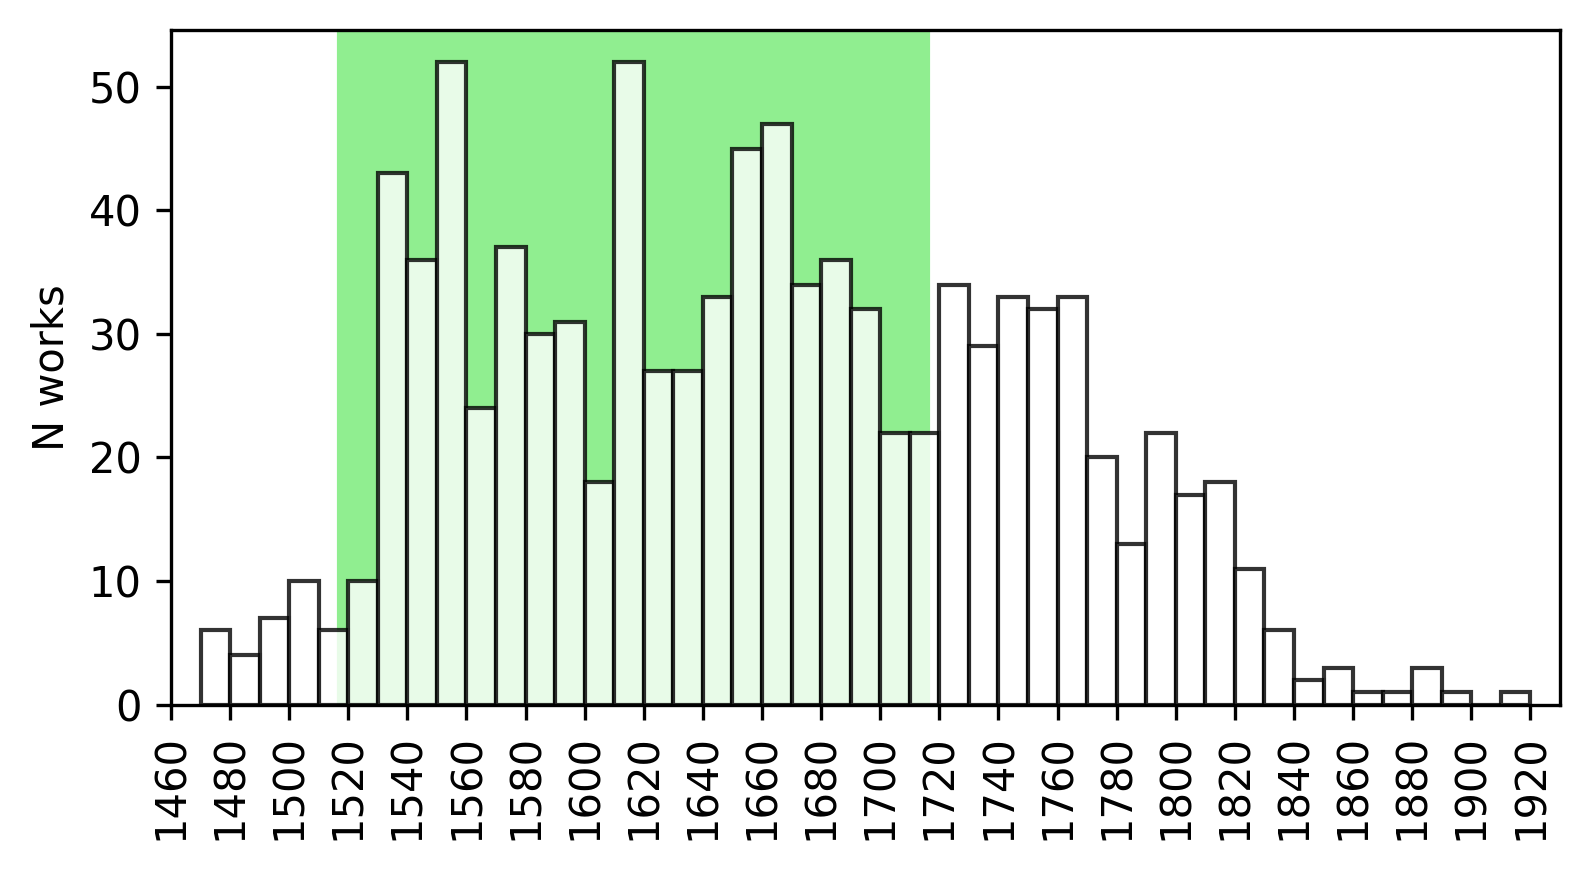

In [11]:
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=300, tight_layout=True)
ax.axvspan(1517, 1716, color="lightgreen")
metadata_table_long["file_year"].plot.hist(bins=range(1470,1930,10), ec="black", color="white", alpha=0.8, ax=ax)
ax.set_xticks(range(1460,1960,20))
ax.set_xticklabels([str(n) for n in range(1460,1960,20)], rotation=90)
ax.set_ylabel("N works")
ax.set_xlim(1460, 1930)

In [12]:
fig.savefig("../figures/noscemus_works_tempdist.png")

# Count number of words and sentences for each work and add this info to the metadata

In [14]:
id = metadata_table_long["id"][1]

In [4]:
#!curl https://sciencedata.dk/public/87394f685b79e7f1ebd4a7ead2b4941c/sents_lemmata.zip -o ../data/large_data/sents_lemmata.zip
#!curl https://sciencedata.dk/public/87394f685b79e7f1ebd4a7ead2b4941c/sents_pos.zip -o ../data/large_data/sents_pos.zip
# shutil.unpack_archive("../data/large_data/sents_lemmata.zip", "../data/large_data/sents_lemmata")
# shutil.unpack_archive("../data/large_data/sents_pos.zip", "../data/large_data/sents_pos")

In [180]:
source_path = "/srv/data/tome/noscemus/sents_data/"
# alternatively, we can use lower case version of all texts:
# source_path = "/srv/data/tome/noscemus/sents_data_lower/"
filenames_list = os.listdir(source_path)
filenames_list[:10]

['725075.pickle',
 '928138.pickle',
 '985903.pickle',
 '733505.pickle',
 '739101.pickle',
 '702145.pickle',
 '906214.pickle',
 '902259.pickle',
 '901017.pickle',
 '904418.pickle']

In [181]:
# test: loading back individual file
f_sents_data = pickle.load(open(source_path + filenames_list[20], "rb"))
f_sents_data[111:115]

[('Uerumenim uero inpraesentiarum id me male habet, quod adhuc uiderim aliquam rixandi necessitatem, & serram contentionis reciprocandi, dum ipsi nouae Philosophiae Principes, de Plenitudine Mundi non conueniunt, adeoque in ipso limine caespitant &c. Quia uero jam olim Philosophi inter sese de Uacuo, an?',
  [('Uerumenim', 'uerumenim', 'PART', (0, 9)),
   ('uero', 'uero', 'ADV', (10, 14)),
   ('inpraesentiarum', 'inpraesentia', 'NOUN', (15, 30)),
   ('id', 'is', 'PRON', (31, 33)),
   ('me', 'ego', 'PRON', (34, 36)),
   ('male', 'male', 'ADV', (37, 41)),
   ('habet', 'habeo', 'VERB', (42, 47)),
   (',', ',', 'PUNCT', (47, 48)),
   ('quod', 'qui', 'PRON', (49, 53)),
   ('adhuc', 'adhuc', 'ADV', (54, 59)),
   ('uiderim', 'uideo', 'VERB', (60, 67)),
   ('aliquam', 'aliqui', 'DET', (68, 75)),
   ('rixandi', 'rixor', 'VERB', (76, 83)),
   ('necessitatem', 'necessitas', 'NOUN', (84, 96)),
   (',', ',', 'PUNCT', (96, 97)),
   ('&', '&', 'PUNCT', (98, 99)),
   ('serram', 'serra', 'NOUN', (100, 

In [182]:
def get_filtered_lemmatized_sentences(f_sents_data):
    lemmatized_sents = []
    for sent_data in f_sents_data:
        lemmatized_sents.append([t[1] for t in sent_data[1] if t[2] in ["NOUN", "VERB", "ADJ", "PROPN"]])
    return lemmatized_sents

In [183]:
lemmatized_sents = get_filtered_lemmatized_sentences(f_sents_data)
lemmatized_sents[111:115]

[['inpraesentia',
  'habeo',
  'uideo',
  'rixor',
  'necessitas',
  'serra',
  'contentio',
  'reciproco',
  'nouus',
  'Philosophiaa',
  'principes',
  'plenitudo',
  'Mundus',
  'conuenio',
  'limen',
  'caespito',
  'philosophi',
  'uacuus'],
 [],
 [],
 ['disputo',
  'sententia',
  'concipio',
  'mordicus',
  'miles',
  'arx',
  'oppugno',
  'hostis',
  'defendo']]

In [184]:
lemmata = [l for s in lemmatized_sents for l in s]
lemmata[:20]

['Otto',
 'Guerickeus',
 'experimentum',
 'nouus',
 'uoco',
 'Magdeburgica',
 'uacuus',
 'spatium',
 'Amstelodamus',
 'Joan',
 'Janssonium',
 'Waesberga',
 '',
 'Guerickeus',
 'Emerienius',
 'nouus',
 'uoco',
 'Magdeburgica',
 'uacuus',
 'siatio']

In [185]:
word_counts = dict(nltk.FreqDist(lemmata).most_common())

In [186]:
%%time
vocab_counter = Counter()
overview_dict = {}
for filename in filenames_list:
    f_sents_data = pickle.load(open(source_path + filename, "rb"))
    sents_n = len(f_sents_data)
    tokens_n = 0
    lemmata = []
    for sent_data in f_sents_data:
        tokens_n += len(sent_data[1])
        lemmata.extend([t[1] for t in sent_data[1] if t[2] in ["NOUN", "VERB", "ADJ", "PROPN"]])
    #lemmata = [l for l in lemmata if (l != "") & (len(l) > 2) & ("." not in l)]
    lemmata = [l for l in lemmata if l and len(l) > 2 and l.isalpha()]
    overview_dict[filename.partition(".")[0]] = {"sents_n" : sents_n, "tokens_n" : tokens_n} 
    word_counts = dict(nltk.FreqDist(lemmata).most_common())
    vocab_counter.update(word_counts)

CPU times: user 2min 2s, sys: 994 ms, total: 2min 3s
Wall time: 2min 3s


In [187]:
sum(vocab_counter.values())

55091647

In [188]:
list(overview_dict.items())[:10]

[('725075', {'sents_n': 75559, 'tokens_n': 1005937}),
 ('928138', {'sents_n': 10078, 'tokens_n': 92688}),
 ('985903', {'sents_n': 3257, 'tokens_n': 51638}),
 ('733505', {'sents_n': 207, 'tokens_n': 2161}),
 ('739101', {'sents_n': 6745, 'tokens_n': 69355}),
 ('702145', {'sents_n': 4878, 'tokens_n': 99365}),
 ('906214', {'sents_n': 15141, 'tokens_n': 142353}),
 ('902259', {'sents_n': 670, 'tokens_n': 10315}),
 ('901017', {'sents_n': 1538, 'tokens_n': 22635}),
 ('904418', {'sents_n': 10140, 'tokens_n': 160211})]

In [189]:
# enrich the metadata table by info on number of words and number of sentences
def get_sents_n(id):
    try:
        return overview_dict[str(id)]["sents_n"]
    except:
        return None
metadata_table_long["sents_n"] = metadata_table_long["id"].apply(get_sents_n)

def get_tokens_n(id):
    try:
        return overview_dict[str(id)]["tokens_n"]
    except:
        return None
metadata_table_long["tokens_n"] = metadata_table_long["id"].apply(get_tokens_n)
metadata_table_long.head(5)

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,...,ids,id,date_min,date_max,filename,file_year,sents_n,tokens_n,disciplines_list,science_class
0,"Achrelius, Daniel",Scientiarum magnes recitatus publice anno 1690...,NaN,1690,[Turku],Wall,17th century,Oration,"Mathematics, Astronomy/Astrology/Cosmography, ...",Scientiarum magnes(Google Books),...,[705665],705665,1690.0,1690.0,"Achrelius,_Daniel_-_Scientiarum_magnes__Turku_...",1690.0,630,8839,"[Mathematics, Astronomy/Astrology/Cosmography,...",mixture
1,"Acidalius, Valens","Ad Iordanum Brunum Nolanum, Italum","Poematum Iani Lernutii, Iani Gulielmi, Valenti...",1603,"Liegnitz, Wrocław","Albert, David",17th century,Panegyric poem,Astronomy/Astrology/Cosmography,Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...,...,[801745],801745,1603.0,1603.0,Janus_Lernutius_et_al__-_Poemata__Liegnitz_160...,1603.0,6527,82445,[Astronomy/Astrology/Cosmography],exact_sciences
2,"Acosta, José de",De natura novi orbis libri duo et De promulgat...,NaN,1589,Salamanca,Guillelum Foquel,16th century,Monograph,"Astronomy/Astrology/Cosmography, Geography/Car...",De natura novi orbis(Biodiversity Heritage Lib...,...,[713323],713323,1589.0,1589.0,"Acosta,_José_de_-_De_natura_novi_orbis__Salama...",1589.0,8905,170205,"[Astronomy/Astrology/Cosmography, Geography/Ca...",exact_sciences
3,"Adam, Melchior","Vitae Germanorum medicorum, qui saeculo superi...",NaN,1620,Heidelberg,"Rosa, Geyder",17th century,Biography,Medicine,Vitae Germanorum medicorum(MDZ)Alternative lin...,...,[693148],693148,1620.0,1620.0,"Adam,_Melchior_-_Vitae_Germanorum_medicorum__H...",1620.0,17961,193272,[Medicine],life_sciences
4,"Addison, Joseph",Ad insignissimum virum dominum Thomam Burnettu...,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Panegyric poem,Meteorology/Earth sciences,Ad Burnettum sacrae theoriae telluris auctorem...,...,[769230],769230,1698.0,1698.0,Examen_poeticum_duplex__London_1698_pdf.txt,1698.0,3533,47878,[Meteorology/Earth sciences],exact_sciences


In [190]:
metadata_table_long["tokens_n"].sum()

137325383

# Overview by Discipline/Content

In [191]:
# numbers of sentences and words by "Discipline/Content
# the Discipline/Content column has 115 unique values, so this does not produce that much meaningful output
metadata_table_long.groupby("Discipline/Content").sum()[["sents_n", "tokens_n"]].sort_values("tokens_n", ascending=False)

,sents_n,tokens_n
Discipline/Content,,
Medicine,3181510,29047659
Biology,1442391,16335340
Astronomy/Astrology/Cosmography,829951,13706603
Mathematics,615962,9303844
"Biology, Medicine",602593,7278801
...,...,...
"Physics, Biology, Medicine, Other (see description)",405,8466
"Mathematics, Physics, Astronomy/Astrology/Cosmography, Meteorology/Earth sciences, Medicine, Other (see description)",448,6166
"Physics, Astronomy/Astrology/Cosmography, Medicine",291,5144


In [192]:
# let's create a list of disciplines for each work
def get_disciplines_list(string):
    try:
        disciplines_list = string.split(", ")
    except:
        disciplines_list = []
    return disciplines_list
metadata_table_long["disciplines_list"] = metadata_table_long["Discipline/Content"].apply(get_disciplines_list)

In [193]:
# count number of works associated with each discipline
# WARNING: the categories are overlapping here!
nltk.FreqDist([el for ls in metadata_table_long["disciplines_list"] for el in ls]).most_common(50)

[('Medicine', 356),
 ('Biology', 271),
 ('Astronomy/Astrology/Cosmography', 269),
 ('Mathematics', 213),
 ('Meteorology/Earth sciences', 204),
 ('Physics', 180),
 ('Geography/Cartography', 134),
 ('Other (see description)', 123),
 ('Alchemy/Chemistry', 103)]

In [194]:
# to-do: natural history vs natural philosophy

In [195]:
ls = ['Mathematics',
      'Physics',
      'Geography/Cartography',
      'Meteorology/Earth sciences',
      'Alchemy/Chemistry',
      'Biology',
      'Medicine']

In [196]:
# let introduce a heuristic distinction between life and physical sciences
life_sciences = ['Medicine', 'Biology']
physical_sciences = ['Astronomy/Astrology/Cosmography', 'Meteorology/Earth sciences', 'Mathematics', 'Physics', 'Geography/Cartography', 'Alchemy/Chemistry']

In [197]:
bool(set(ls).intersection(set(life_sciences)))

True

In [198]:
def get_science_class(ls):
    if bool(set(ls).intersection(set(life_sciences))):
        if bool(set(ls).intersection(set(physical_sciences))):
            science_class = "mixture"
        else:
            science_class = "life_sciences"
    else:
        science_class = "exact_sciences"
    return science_class

In [199]:
metadata_table_long["science_class"] = metadata_table_long["disciplines_list"].apply(get_science_class)

In [200]:
# inspect the table now
metadata_table_long.head(5)

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,...,ids,id,date_min,date_max,filename,file_year,sents_n,tokens_n,disciplines_list,science_class
0,"Achrelius, Daniel",Scientiarum magnes recitatus publice anno 1690...,NaN,1690,[Turku],Wall,17th century,Oration,"Mathematics, Astronomy/Astrology/Cosmography, ...",Scientiarum magnes(Google Books),...,[705665],705665,1690.0,1690.0,"Achrelius,_Daniel_-_Scientiarum_magnes__Turku_...",1690.0,630,8839,"[Mathematics, Astronomy/Astrology/Cosmography,...",mixture
1,"Acidalius, Valens","Ad Iordanum Brunum Nolanum, Italum","Poematum Iani Lernutii, Iani Gulielmi, Valenti...",1603,"Liegnitz, Wrocław","Albert, David",17th century,Panegyric poem,Astronomy/Astrology/Cosmography,Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...,...,[801745],801745,1603.0,1603.0,Janus_Lernutius_et_al__-_Poemata__Liegnitz_160...,1603.0,6527,82445,[Astronomy/Astrology/Cosmography],exact_sciences
2,"Acosta, José de",De natura novi orbis libri duo et De promulgat...,NaN,1589,Salamanca,Guillelum Foquel,16th century,Monograph,"Astronomy/Astrology/Cosmography, Geography/Car...",De natura novi orbis(Biodiversity Heritage Lib...,...,[713323],713323,1589.0,1589.0,"Acosta,_José_de_-_De_natura_novi_orbis__Salama...",1589.0,8905,170205,"[Astronomy/Astrology/Cosmography, Geography/Ca...",exact_sciences
3,"Adam, Melchior","Vitae Germanorum medicorum, qui saeculo superi...",NaN,1620,Heidelberg,"Rosa, Geyder",17th century,Biography,Medicine,Vitae Germanorum medicorum(MDZ)Alternative lin...,...,[693148],693148,1620.0,1620.0,"Adam,_Melchior_-_Vitae_Germanorum_medicorum__H...",1620.0,17961,193272,[Medicine],life_sciences
4,"Addison, Joseph",Ad insignissimum virum dominum Thomam Burnettu...,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Panegyric poem,Meteorology/Earth sciences,Ad Burnettum sacrae theoriae telluris auctorem...,...,[769230],769230,1698.0,1698.0,Examen_poeticum_duplex__London_1698_pdf.txt,1698.0,3533,47878,[Meteorology/Earth sciences],exact_sciences


In [201]:
class_df = metadata_table_long.groupby("science_class").sum()[["tokens_n"]]

In [202]:
class_df

,tokens_n
science_class,
exact_sciences,56004454
life_sciences,55557806
mixture,25763123


Text(0, 0.5, 'tokens n')

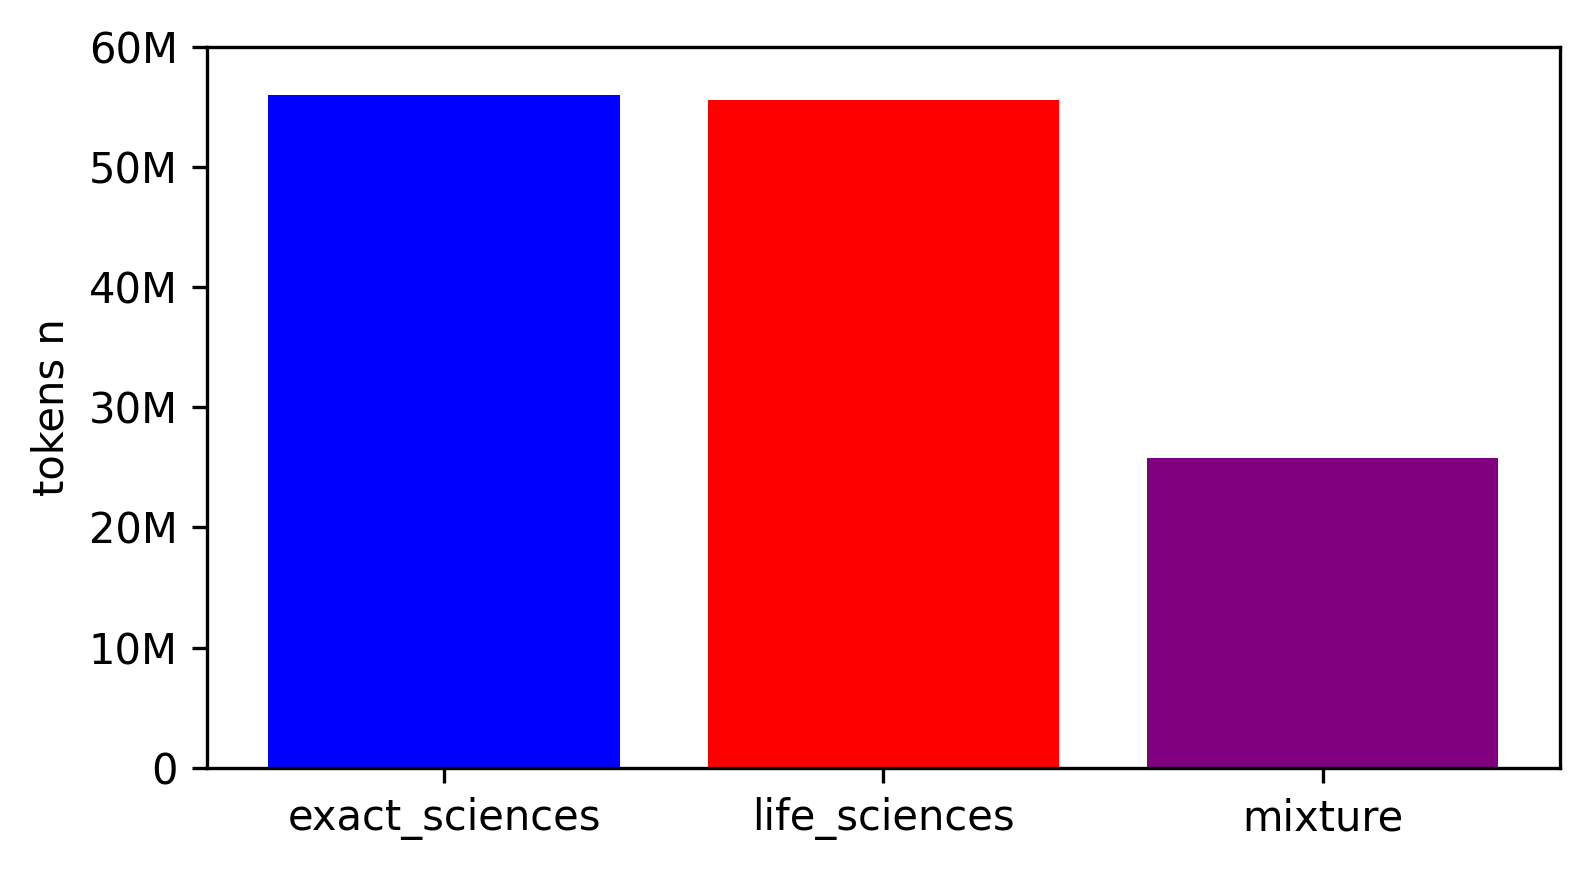

In [203]:
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=300, tight_layout=True)
plt.bar(x=class_df.index, height=class_df["tokens_n"], color=["blue", "red", "purple"])
ax.set_yticks(range(0,70000000, 10000000))
ax.set_yticklabels(["0"] + [str(el)+"M" for el in range(10,70,10)])
ax.set_ylabel("tokens n")

In [204]:
fig.savefig("../figures/science-class_bar.png")

## Temporal distributions of tokens

Text(0, 0.5, 'tokens n')

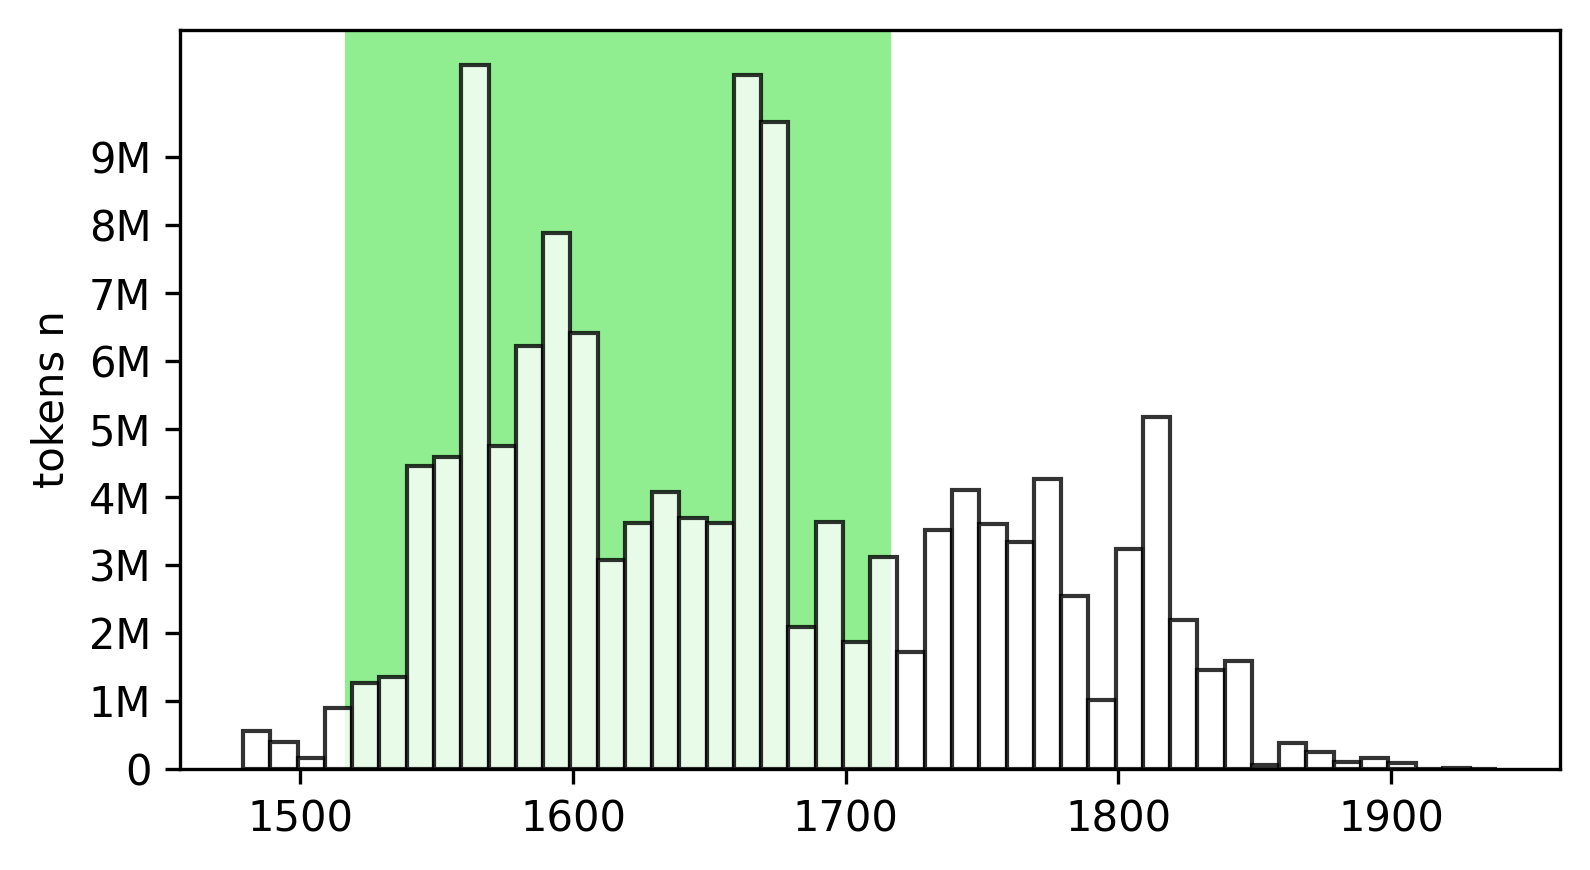

In [205]:
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=300, tight_layout=True)

data = []
for start in range(1470,1930,10):
    end = start + 9
    subset = metadata_table_long[metadata_table_long["file_year"].between(start, end)]
    tokens_n = subset["tokens_n"].sum()
    data.append((start, end, tokens_n))

ax.axvspan(1517, 1716, color="lightgreen")
ax.bar(x=[el[1]+5 for el in data], height=[el[2] for el in data], align='center', color="white", edgecolor="black", alpha=0.8, width=10)
ax.set_yticks(range(0,10000000, 1000000))
ax.set_yticklabels(["0"] + [str(el)+"M" for el in range(1,10)])
ax.set_ylabel("tokens n")

In [206]:
fig.savefig("../figures/noscemus_tempdist_words.png")

In [207]:
for start in range(1501,1701,50):
    end = start + 49
    print(start, end)

1501 1550
1551 1600
1601 1650
1651 1700


Text(0, 0.5, 'tokens n')

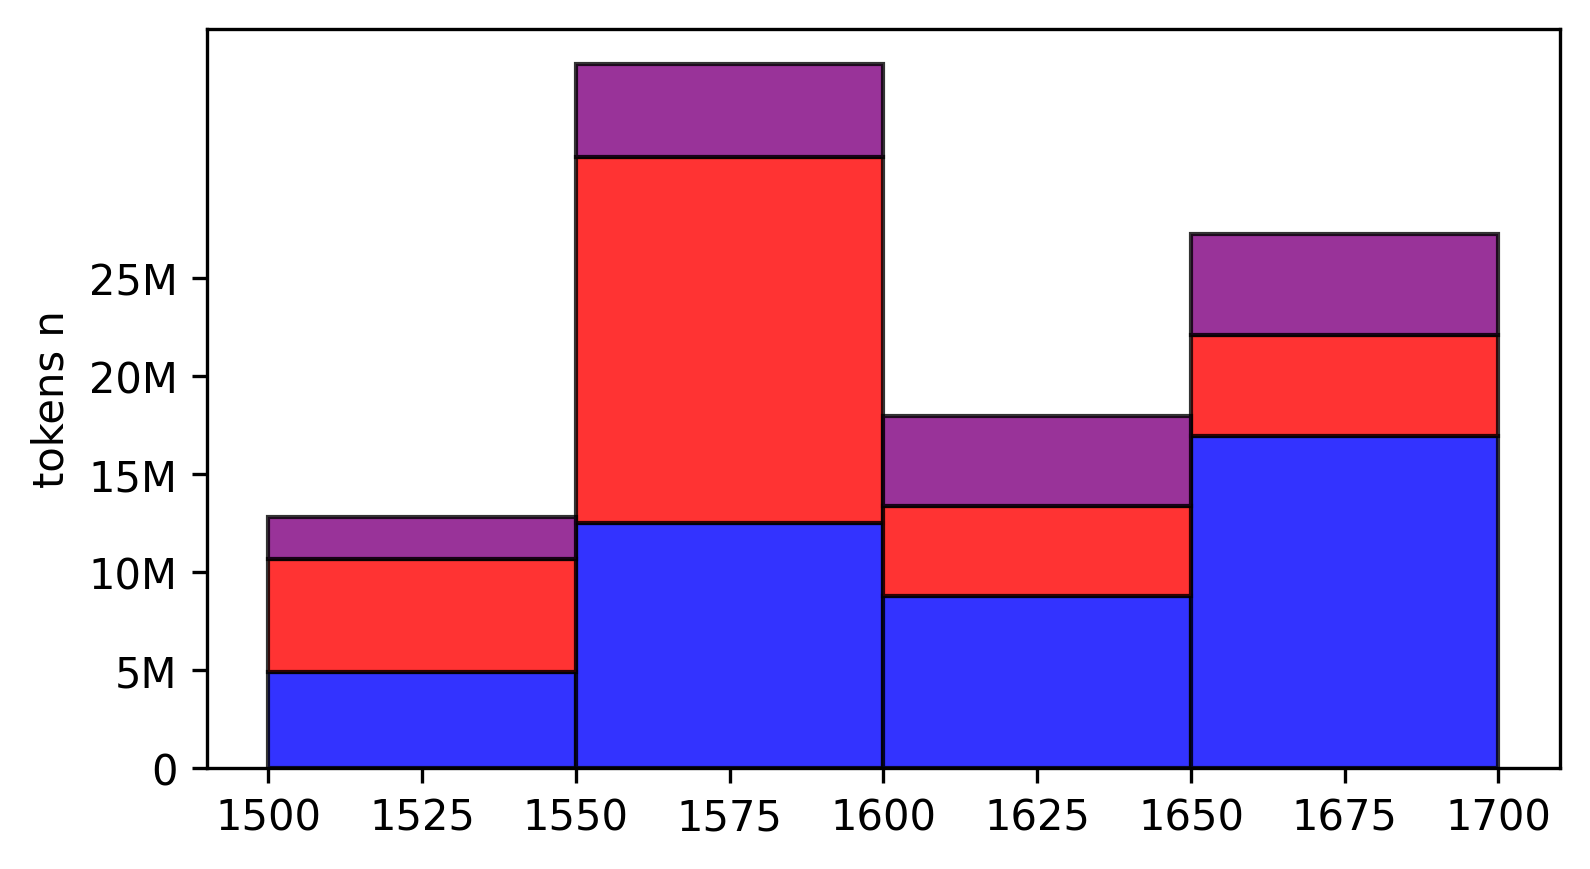

In [208]:
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=300, tight_layout=True)

bottom = np.array([0,0,0,0])
for cl, color in zip(["exact_sciences", "life_sciences", "mixture"], ["blue", "red", "purple"]):
    class_subset = metadata_table_long[metadata_table_long["science_class"]==cl]
    data = []
    for start in range(1501,1701,50):
        end = start + 49
        subset = class_subset[class_subset["file_year"].between(start, end)]
        tokens_n = subset["tokens_n"].sum()
        data.append((start, end, tokens_n))
    height = [el[2] for el in data]
    ax.bar(x=[el[0]+24 for el in data], height=height, align='center', color=color, edgecolor="black", bottom=bottom,alpha=0.8, width=50)
    bottom += np.array(height)
# ax.axvspan(1517, 1716, color="lightgreen")
ax.set_yticks(range(0,30000000, 5000000))
ax.set_yticklabels(["0"] + [str(el)+"M" for el in range(5,30,5)])
ax.set_ylabel("tokens n")

In [209]:
fig.savefig("../figures/halfcents_bar_stacked.png")

In [210]:
subset = metadata_table_long[metadata_table_long["science_class"]=="life_sciences"].sort_values("tokens_n", ascending=False)
subset

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,...,ids,id,date_min,date_max,filename,file_year,sents_n,tokens_n,disciplines_list,science_class
153,"Brasavola, Antonio Musa","Antonii Musae Brasavoli, medici Ferrariensis, ...",NaN,1586,Venice,Giunti,16th century,"Dictionary/Lexicon, Other (see description), E...",Medicine,Index refertissimus in omnes Galeni libros(Goo...,...,[833195],833195,1586.0,1586.0,"Brasavola,_Antonio_Musa_-_Index_refertissimus_...",1586.0,373015,2278489,[Medicine],life_sciences
689,"Paulinus, Fabius","Ad clarissimum virum Laurentium Massam, sereni...","Avicennae, Arabum medicorum principis, ex Gera...",1595,Venice,I Giunti,16th century,Panegyric poem,Medicine,Ad Laurentium Massam pro Avicenna ode(Google B...,...,[900763],900763,1595.0,1595.0,"Costeo,_Giovanni_&_Mongio,_Paolo_-_Avicennae_c...",1595.0,91713,1243369,[Medicine],life_sciences
366,"Gessner, Conrad",Historia animalium,NaN,1551; 1554; 1555; 1558,Zurich,Froschauer,16th century,"Historia, Encyclopedic work",Biology,"Historia animalium, vol. 1,vol. 2,vol. 3,vol. ...",...,"[756856, 766507, 756854, 756853]",756856,1551.0,1558.0,"Gessner,_Conrad_-_Historia_animalium__Vol__1__...",1551.0,81685,1204986,[Biology],life_sciences
67,Bartholomaeus de Montagna,[no title],NaN,[1476],[Padua],"[Teutonicus, Fridericus Johannis]",15th century since invention of printing,"Letter, Other (see description)",Medicine,"Consilia(MDZ),ConsiliainSelectiora opera(Frank...",...,[901145],901145,1476.0,1476.0,Bartholomaeus_de_Montagna_-_Consilia__Venice_1...,1565.0,98499,1202721,[Medicine],life_sciences
355,"Gessner, Conrad",Historia animalium,NaN,1551; 1554; 1555; 1558,Zurich,Froschauer,16th century,"Historia, Encyclopedic work",Biology,"Historia animalium, vol. 1,vol. 2,vol. 3,vol. ...",...,"[756856, 766507, 756854, 756853]",756853,1551.0,1558.0,"Gessner,_Conrad_-_Historia_animalium__Vol__4__...",1558.0,85291,1162452,[Biology],life_sciences
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,"Schreyer, Johann",Relatio de monstro vitulino-humano a domino do...,Acta eruditorum anno MDCLXXXII publicata ac se...,1682,Leipzig,"Günther, Christoph",17th century,Journal Paper,"Biology, Medicine",Relatio de monstro vitulino-humano(IZWT Wupper...,...,[720611],720611,1682.0,1682.0,Acta_eruditorum_1682__Leipzig_1682pdf.txt,1682.0,90,1750,"[Biology, Medicine]",life_sciences
252,"Detharding, Georg Christoph","Rectore academiae magnificentissimo, serenissi...",NaN,1753,Rostock,Adler,18th century,Other (see description),Medicine,Invitatio ad anatomiam publicam(Universität Ro...,...,[897259],897259,1753.0,1753.0,"Detharding,_Georg_Christoph_-_Invitatio_ad_ana...",1753.0,54,1276,[Medicine],life_sciences
580,"Lloyd, Philip",De partium septentrionalium quibusdam affectib...,Philosophical Transactions of the Royal Societ...,1699,NaN,NaN,17th century,Journal Paper,Medicine,De partium septentrionalium quibusdam affectib...,...,[864509],864509,1699.0,1699.0,"Lloyd,_Philipp_-_De_partium_septentrionalium_q...",1699.0,69,1252,[Medicine],life_sciences
28,Anonymus 15,Symbolum Oenipontanum. Ynsbrugger Warzaichen. ...,NaN,1620,Innsbruck,Paur,17th century,Other (see description),"Medicine, Other (see description)",Der kranck oder krumme Tischler zu Ynsprugg(Br...,...,[928693],928693,1620.0,1620.0,Anonymus_15_-_Symbolum_Oenipontanum__Innsbruck...,1620.0,14,361,"[Medicine, Other (see description)]",life_sciences


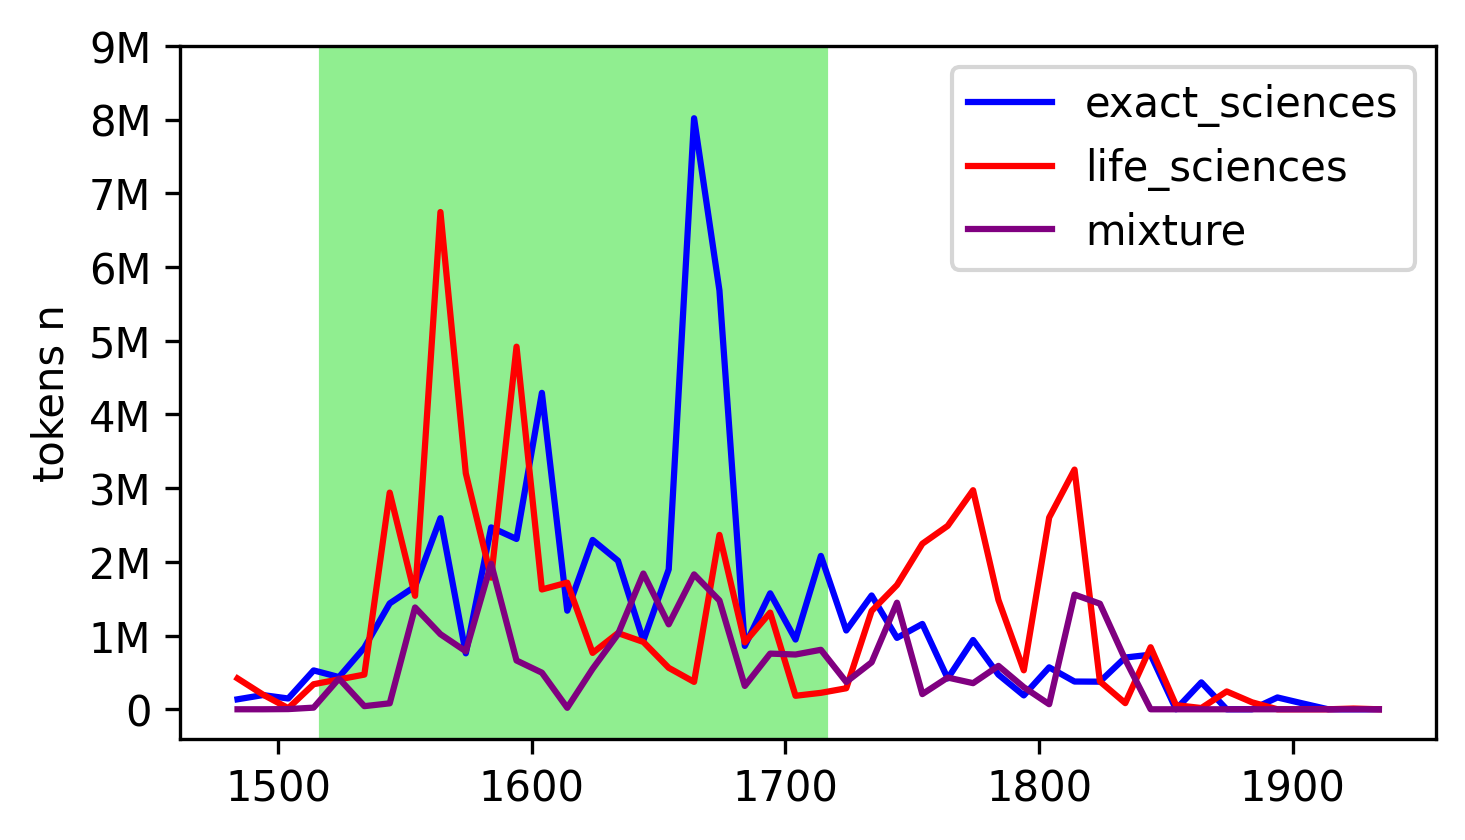

In [211]:
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=300)

for cl, color in zip(["exact_sciences", "life_sciences", "mixture"], ["blue", "red", "purple"]):
    subset = metadata_table_long[metadata_table_long["science_class"]==cl]
    data = []
    for start in range(1470,1930,10):
        end = start + 9
        subset_temporal = subset[subset["file_year"].between(start, end)]
        tokens_n = subset_temporal["tokens_n"].sum()
        data.append((start, end, tokens_n))
    
    
    ax.plot([el[1]+5 for el in data], [el[2] for el in data], label=cl, color=color) # , align='center', color="white", edgecolor="black", alpha=0.8, width=10)
ax.axvspan(1517, 1716, color="lightgreen")
ax.set_yticks(range(0,10000000, 1000000))
ax.set_yticklabels(["0"] + [str(el)+"M" for el in range(1,10)])
ax.set_ylabel("tokens n")
ax.set_title("")
ax.legend()

In [212]:
fig.savefig("../figures/tempdist_scclasses_lines.png")

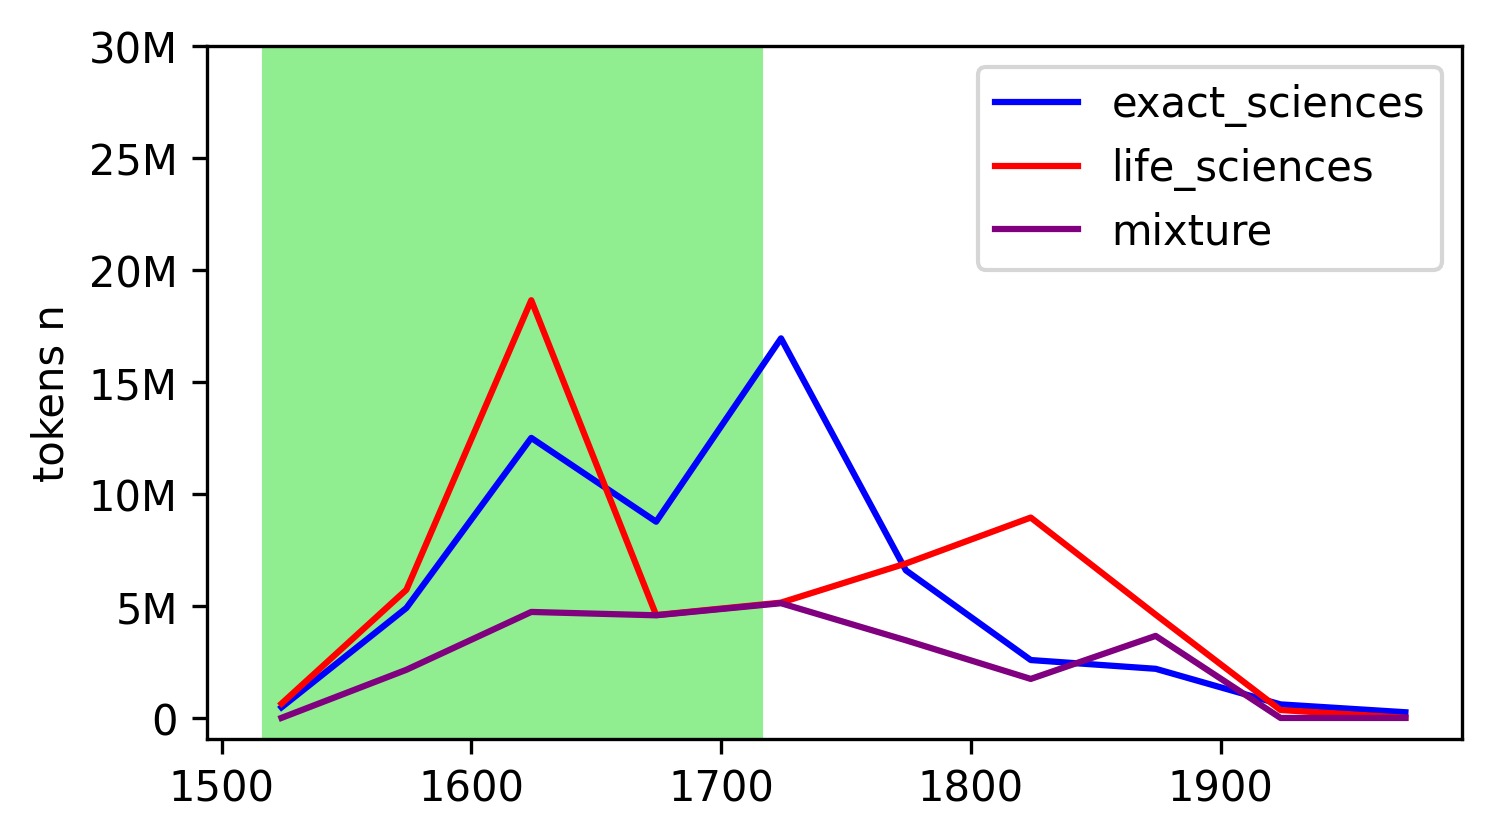

In [213]:
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=300)

for cl, color in zip(["exact_sciences", "life_sciences", "mixture"], ["blue", "red", "purple"]):
    subset = metadata_table_long[metadata_table_long["science_class"]==cl]
    data = []
    for start in range(1451,1951,50):
        end = start + 49
        subset_temporal = subset[subset["file_year"].between(start, end)]
        tokens_n = subset_temporal["tokens_n"].sum()
        data.append((start, end, tokens_n))

    ax.plot([el[1]+24 for el in data], [el[2] for el in data], label=cl, color=color) # , align='center', color="white", edgecolor="black", alpha=0.8, width=10)

ax.axvspan(1517, 1716, color="lightgreen")
ax.set_yticks(range(0,35000000, 5000000))
ax.set_yticklabels(["0"] + [str(el)+"M" for el in range(5,35,5)])
ax.set_ylabel("tokens n")
ax.legend()

In [214]:
metadata_table_long.to_json("../data/metadata_table_long.json")

In [215]:
#set_with_dataframe(noscemus_gs.add_worksheet("metadata_table_long_v5", 1,1), metadata_table_long)

# Temporal analysis of coocuccerences - development & testing

In [216]:
%%time
target = "harmonia" # choose your target word, ie. the word which's context you want to investigate
start = 1551 # choose the start your of the period under 
end = start + 49 # end of the period
ids = metadata_table_long[metadata_table_long["file_year"].between(start, end)]["id"] # use the metadata table to extract IDs of all works falling into this period
vocab_counter = Counter() # initiate an empty counter of words - we will feed it iterarively on the go by all words we meet
target_sents = [] # initiate an empty list of sentences containing the target word
for id in ids: # for each work ID from our subset of IDs
    # based on the ID, open the file containing the lemmatized sentences
    f_sents_data = pickle.load(open(source_path + str(id) + ".pickle", "rb"))
    sents_n = len(f_sents_data)
    tokens_n = 0
    lemmata = []
    target_sents_local = []
    for sent_data in f_sents_data:
        tokens_n += len(sent_data[1])
        filtered_sent = [t[1] for t in sent_data[1] if t[2] in ["NOUN", "VERB", "ADJ", "PROPN"]]
        filtered_sent = [l for l in filtered_sent if l and len(l) > 2 and l.isalpha()]
        if target in filtered_sent:
            target_sents_local.append(filtered_sent)
        lemmata.extend(filtered_sent)
    target_sents.extend(target_sents_local)
    overview_dict[filename.partition(".")[0]] = {"sents_n" : sents_n, "tokens_n" : tokens_n} 
    word_counts = dict(nltk.FreqDist(lemmata).most_common())
    vocab_counter.update(word_counts)
target_coocs_counts = dict(nltk.FreqDist([t for s in target_sents for t in s]).most_common())
target_coocs_n = sum(target_coocs_counts.values())
target_coocs_freqs = dict([(tup[0], tup[1] / target_coocs_n) for tup in target_coocs_counts.items()])
words_n = sum(vocab_counter.values())
words_freqs = dict([(tup[0], tup[1] / words_n) for tup in vocab_counter.items()])

CPU times: user 29.8 s, sys: 412 ms, total: 30.2 s
Wall time: 30.2 s


In [217]:
len(target_sents)

549

In [218]:
print(target_sents[:5])

[['harmonia', 'synceo', 'animus', 'corpus', 'habeo'], ['harmonia', 'synceo', 'animus', 'corpus', 'habeo'], ['assequor', 'compositio', 'animus', 'corpus', 'consensus', 'musicus', 'imitor', 'pars', 'pars', 'conuenio', 'ago', 'pars', 'agnosco', 'reclamo', 'pars', 'harmonia', 'existo', 'onium', 'dico', 'uisus', 'auditus', 'iucundissimus'], ['uox', 'sonus', 'modus', 'harmonia', 'tracto', 'musicus', 'necesse', 'medicus', 'musicus', 'habeo', 'corpus', 'harmonia', 'concentus', 'oculus', 'habeo', 'specto'], ['haliabbas', 'harmonia', 'synceo', 'animus', 'corpus', 'habeo', 'herba', 'metallum', 'cia', 'puer', 'sum', 'medicus', 'cognosco', 'Herculanus', 'Hermalaus', 'barbarus', 'Herophilus', 'uetus', 'mos', 'manus', 'anatomen', 'gredior', 'audeo', 'Higiina', 'Hippocras', 'Gaelenus', 'medicus', 'philosophus', 'Plato', 'stotelis']]


In [219]:
list(target_coocs_counts.items())[:10]

[('harmonia', 580),
 ('corpus', 88),
 ('anima', 59),
 ('dico', 55),
 ('motus', 53),
 ('numerus', 48),
 ('habeo', 47),
 ('coelestis', 47),
 ('facio', 46),
 ('pars', 44)]

In [220]:
target_coocs_freqs_weighted = {}
for key in target_coocs_freqs.keys():
    target_coocs_freqs_weighted[key] = np.round(np.log((target_coocs_freqs[key])**2 / (words_freqs[key] * words_freqs[target])), 2)
for tup in sorted(target_coocs_freqs_weighted.items(), key=lambda x:x[1], reverse=True)[:20]:
    print(tup + (vocab_counter[tup[0]], target_coocs_counts[tup[0]]))

('harmonia', 15.28, 580, 580)
('concentus', 9.81, 255, 25)
('concinentia', 9.61, 2, 2)
('phonga', 9.61, 2, 2)
('diapasson', 9.61, 2, 2)
('consentientus', 9.61, 2, 2)
('gomphosus', 9.21, 3, 2)
('symphyseus', 9.0, 23, 5)
('porisma', 8.94, 48, 7)
('Hermalaus', 8.92, 1, 1)
('eluf', 8.92, 1, 1)
('supertripartientia', 8.92, 1, 1)
('superbipartientia', 8.92, 1, 1)
('sunpcum', 8.92, 1, 1)
('finestra', 8.92, 1, 1)
('Exaedrius', 8.92, 1, 1)
('Octaedrus', 8.92, 1, 1)
('Ihilolaus', 8.92, 1, 1)
('Thaebas', 8.92, 1, 1)
('operapretium', 8.92, 1, 1)


In [221]:
ids = metadata_table_long[metadata_table_long["file_year"].between(start, end)]["id"] # use the metadata table to extract IDs of all works falling into this period

def get_target_mi(ids, target, topn=20, mincount=5):
    vocab_counter = Counter() # initiate an empty counter of words - we will feed it iterarively on the go by all words we meet
    target_sents = [] # initiate an empty list of sentences containing the target word
    for id in ids: # for each work ID from our subset of IDs
        # based on the ID, open the file containing the lemmatized sentences
        f_sents_data = pickle.load(open(source_path + str(id) + ".pickle", "rb"))
        sents_n = len(f_sents_data)
        tokens_n = 0
        lemmata = []
        target_sents_local = []
        for sent_data in f_sents_data:
            tokens_n += len(sent_data[1])
            filtered_sent = [t[1] for t in sent_data[1] if t[2] in ["NOUN", "VERB", "ADJ", "PROPN"]]
            filtered_sent = [l for l in filtered_sent if l and len(l) > 2 and l.isalpha()]
            if target in filtered_sent:
                target_sents_local.append(filtered_sent)
            lemmata.extend(filtered_sent)
        target_sents.extend(target_sents_local)
        overview_dict[filename.partition(".")[0]] = {"sents_n" : sents_n, "tokens_n" : tokens_n} 
        word_counts = dict(nltk.FreqDist(lemmata).most_common())
        vocab_counter.update(word_counts)
    target_coocs_counts = dict(nltk.FreqDist([t for s in target_sents for t in s]).most_common())
    target_coocs_n = sum(target_coocs_counts.values())
    target_coocs_freqs = dict([(tup[0], tup[1] / target_coocs_n) for tup in target_coocs_counts.items()])
    words_n = sum(vocab_counter.values())
    words_freqs = dict([(tup[0], tup[1] / words_n) for tup in vocab_counter.items()])
    target_coocs_freqs_weighted = {}
    for key in target_coocs_freqs.keys():
        target_coocs_freqs_weighted[key] = np.log((target_coocs_freqs[key])**2 / (words_freqs[key] * words_freqs[target]))
    target_coocs_topN = list(sorted(target_coocs_freqs_weighted.items(), key=lambda x:x[1], reverse=True))[1:topn +1]
    target_coocs_topN = [(tup[0], tup[1], vocab_counter[tup[0]], target_coocs_counts[tup[0]]) for tup in target_coocs_topN]
    return target_coocs_topN
    

In [113]:
# test
start = 1601
end = 1603
ids = metadata_table_long[metadata_table_long["file_year"].between(start, end)]["id"] # use the metadata table to extract IDs of all works falling into this period
target = "harmonia"
get_target_mi(ids, target)

[('gomphosis', 10.07139736567225, 21, 13),
 ('sutura', 9.070878002072224, 488, 38),
 ('gomphosum', 8.27370316092438, 3, 2),
 ('gomphosus', 7.986021088472599, 4, 2),
 ('solicitudo', 7.986021088472599, 1, 1),
 ('synarthroscus', 7.986021088472599, 1, 1),
 ('ruditas', 7.986021088472599, 1, 1),
 ('praenotatis', 7.986021088472599, 1, 1),
 ('synchrondrosis', 7.986021088472599, 1, 1),
 ('supplo', 7.986021088472599, 1, 1),
 ('prauo', 7.986021088472599, 1, 1),
 ('mancusue', 7.986021088472599, 1, 1),
 ('diarthosus', 7.986021088472599, 1, 1),
 ('arthru', 7.986021088472599, 1, 1),
 ('airus', 7.986021088472599, 1, 1),
 ('gompho', 7.986021088472599, 1, 1),
 ('gomphose', 7.986021088472599, 1, 1),
 ('mistura', 7.986021088472599, 1, 1),
 ('maxilledes', 7.986021088472599, 1, 1),
 ('ofla', 7.986021088472599, 1, 1)]

In [114]:
periods = [(1501, 1550),
           (1551, 1600),
           (1601, 1650),
           (1651, 1700)]
data = []
for per in periods:
    ids = metadata_table_long[metadata_table_long["file_year"].between(per[0], per[1])]["id"] # use the metadata table to extract IDs of all works falling into this period
    data.append([tup[0] for tup in get_target_mi(ids, target)])

In [121]:
harmonia_mi_df = pd.DataFrame(data, index=[str(tup[0])+"-"+str(tup[1]) for tup in periods]).T
harmonia_mi_df

,1501-1550,1551-1600,1601-1650,1651-1700
0,uas,Stephanus,oedemo,enitueeus
1,contilidonis,supergeminalis,Adicus,Ferhreriorum
2,cotilido,subaro,peileps,uipeculiaris
3,sementiuus,pretora,bantecipio,uirodeo
4,plantarium,Carolus,postuxo,capellastinus
5,humidoues,uas,ortasubstantia,stephamus
6,siccor,Glandulosus,Ejaculatorius,quinquencardinalis
7,epidadumon,miasmo,Parastati,Sataudia
8,mekado,moskhouein,Adamantinus,supeuerustas
9,matika,tollitia,Adamantificus,geministerium


In [92]:
set_with_dataframe(noscemus_gs.add_worksheet("harmonia_mi_df_v1", 1,1), harmonia_mi_df)

In [116]:
target = "scientia"
data = []
for per in periods:
    ids = metadata_table_long[metadata_table_long["file_year"].between(per[0], per[1])]["id"] # use the metadata table to extract IDs of all works falling into this period
    data.append([tup[0] for tup in get_target_mi(ids, target)])
scientia_mi_df = pd.DataFrame(data, index=[str(tup[0])+"-"+str(tup[1]) for tup in periods]).T
scientia_mi_df

,1501-1550,1551-1600,1601-1650,1651-1700
0,cognitio,speculatiuus,mathematica,sideralis
1,ars,subalterno,ars,ars
2,astrologia,mathematica,cognitio,staticum
3,Caussa,metaphysica,sideralis,mathematica
4,stella,practicus,syderalis,res
5,mathematica,naturalis,Mathematica,cognitio
6,matix,ars,speculatiuus,naturalis
7,certitudo,cognitio,subalterno,Mathematica
8,sphaeralis,res,res,ingenium
9,spheralis,Mathematica,philosophia,geometria


In [ ]:
target = "seminarium"
data = []
for per in periods:
    ids = metadata_table_long[metadata_table_long["file_year"].between(per[0], per[1])]["id"] # use the metadata table to extract IDs of all works falling into this period
    data.append([tup[0] for tup in get_target_mi(ids, target)])
seminarium_mi_df = pd.DataFrame(data, index=[str(tup[0])+"-"+str(tup[1]) for tup in periods]).T
seminarium_mi_df

In [100]:
set_with_dataframe(noscemus_gs.add_worksheet("seminarium_mi_df_v1", 1,1), seminarium_mi_df)


# Dictionaries explorations...

In [103]:
# go to https://github.com/latin-dict/LewisShort1879/releases and manually download LewisShort1879-stardict.zip to ../data/LewisShort1879-stardict.zip
# extract the archive there

In [122]:
from pystardict import Dictionary

In [123]:
lewisshort = Dictionary("../data/LewisShort1879-stardict/LewisShort1879-lat-eng", in_memory=True)

In [124]:
list(lewisshort.items())[0]

("'st",
 '<dictionary id="LewisShort1879"><style type="text/css">@charset "utf-8";#LewisShort1879 sense{display:block;position:relative;margin-top:.5em}#LewisShort1879 sense:before{content:attr(n);position:absolute;left:-2.5em;width:2em;text-align:right;color:red;font-weight:bold}#LewisShort1879 sense[level="1"]{margin-left:2em}#LewisShort1879 sense[level="2"]{margin-left:4em}#LewisShort1879 sense[level="3"]{margin-left:6em}#LewisShort1879 sense[level="4"]{margin-left:8em}#LewisShort1879 sense[level="5"]{margin-left:10em}#LewisShort1879 sense[level="6"]{margin-left:12em}#LewisShort1879 sense[level="7"]{margin-left:14em}#LewisShort1879 entryfree>sense:first-of-type{display:inline;margin-left:0}#LewisShort1879 entryfree>sense:first-of-type:before{content:""}#LewisShort1879 gen{font-style:italic;color:blue}#LewisShort1879 cit quote{font-style:italic;color:#003478}#LewisShort1879 bibl{color:gray}#LewisShort1879 bibl a:link{text-decoration:none;color:inherit}#LewisShort1879 bibl a:visited{t

In [125]:
word_definitions = {}
for key in lewisshort.keys():
    definition = lewisshort[key]
    word_definitions[key] = definition


In [126]:
word_definitions["harmonia"]

'<dictionary id="LewisShort1879"><style type="text/css">@charset "utf-8";#LewisShort1879 sense{display:block;position:relative;margin-top:.5em}#LewisShort1879 sense:before{content:attr(n);position:absolute;left:-2.5em;width:2em;text-align:right;color:red;font-weight:bold}#LewisShort1879 sense[level="1"]{margin-left:2em}#LewisShort1879 sense[level="2"]{margin-left:4em}#LewisShort1879 sense[level="3"]{margin-left:6em}#LewisShort1879 sense[level="4"]{margin-left:8em}#LewisShort1879 sense[level="5"]{margin-left:10em}#LewisShort1879 sense[level="6"]{margin-left:12em}#LewisShort1879 sense[level="7"]{margin-left:14em}#LewisShort1879 entryfree>sense:first-of-type{display:inline;margin-left:0}#LewisShort1879 entryfree>sense:first-of-type:before{content:""}#LewisShort1879 gen{font-style:italic;color:blue}#LewisShort1879 cit quote{font-style:italic;color:#003478}#LewisShort1879 bibl{color:gray}#LewisShort1879 bibl a:link{text-decoration:none;color:inherit}#LewisShort1879 bibl a:visited{text-decor

In [128]:
%%time
vocab_counter = Counter()
overview_dict = {}
for filename in filenames_list:
    f_sents_data = pickle.load(open(source_path + filename, "rb"))
    sents_n = len(f_sents_data)
    tokens_n = 0
    lemmata = []
    for sent_data in f_sents_data:
        tokens_n += len(sent_data[1])
        lemmata.extend([t[1] for t in sent_data[1] if t[2] in ["NOUN", "VERB", "ADJ", "PROPN"]])
    #lemmata = [l for l in lemmata if (l != "") & (len(l) > 2) & ("." not in l)]
    lemmata = [l for l in lemmata if l and len(l) > 2 and l.isalpha()]
    overview_dict[filename.partition(".")[0]] = {"sents_n" : sents_n, "tokens_n" : tokens_n} 
    word_counts = dict(nltk.FreqDist(lemmata).most_common())
    vocab_counter.update(word_counts)

CPU times: user 2min 4s, sys: 797 ms, total: 2min 5s
Wall time: 2min 5s


In [129]:
N = 50
vocab_thres50 = [tup for tup in zip(vocab_counter.keys(), vocab_counter.values()) if tup[1] >= N]
sum([tup[1] for tup in vocab_thres50]) # how much is covered?

49325247

In [132]:
len(vocab_thres50)

49221